<a href="https://www.kaggle.com/code/nurielreuven/orchids-species-features-classifier?scriptVersionId=105065076" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Orchids Species & Features Classifier
By Nuriel Reuven | Uploaded on 12.8.22

![](https://www.allaboutgardening.com/wp-content/uploads/2021/11/Types-of-Orchids.jpg)

-------------------------------------

### Importing Data

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
from random import sample , randint
from math import floor

from plotly.offline import plot, iplot, init_notebook_mode
import plotly_express as px
init_notebook_mode(connected=True)
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import Input
from keras.models import Sequential
from keras.layers.convolutional import Conv2D , MaxPooling2D
from keras.layers import Activation , Dropout , Flatten , Dense , GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from keras.callbacks import EarlyStopping

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report , confusion_matrix
from imblearn.over_sampling import RandomOverSampler

import warnings
warnings.filterwarnings('ignore')

In the first step, we will import all images and relevant data to our problem:

In [2]:
species=[]
images = []

species_file = '../input/7156-orchid-pictures-156-species/Orchid Flowers Dataset-v1.1/Species_Classifier/ClassLabels.txt'
s_file = open(species_file, "r")

for line in s_file:
    info = line.split(',')
    species.append(info[1].replace('\n',''))
    images.append(info[0].replace('\n',''))

print(f'First images: {images[0:5]} | First species: {species[0:5]} ')

print(f'\nNumber of images: {len(images)} | Number of items on species: {len(species)} ')

First images: ['1.jpg', '2.jpg', '3.jpg', '4.jpg', '5.jpg'] | First species: ['1', '1', '1', '1', '1'] 

Number of images: 7156 | Number of items on species: 7156 


Our primary goal will be detecting species but we will also extract all other features (color, texture, inflorescence etc):

In [3]:
flocol , labcolor , inflor , labchar , no_of_flowers, textures  = [],[],[],[],[],[]
features = {'Flowers Color' : flocol , 'Labell Color' : labcolor , 'Inflorescence' : inflor , 'Labell Char' : labchar , 'No Of Flowers' : no_of_flowers , 'Texture' : textures}

directories = {'Flowers Color' : '../input/7156-orchid-pictures-156-species/Orchid Flowers Dataset-v1.1/Color_Classifier/Version 1/Color_of_Flower_Classifier/Color_of_Flower_Labels.txt' , # Notice that with color there are 2 versions, I prefer version 1
               'Labell Color' : '../input/7156-orchid-pictures-156-species/Orchid Flowers Dataset-v1.1/Color_Classifier/Version 1/Color_of_Labellum_Classifier/Color_of_Labellum_Labels.txt' , # Notice that with color there are 2 versions, I prefer version 1
               'Inflorescence' : '../input/7156-orchid-pictures-156-species/Orchid Flowers Dataset-v1.1/Inflorescence Classifier/Inflorescence_Labels.txt' , 
               'Labell Char' : '../input/7156-orchid-pictures-156-species/Orchid Flowers Dataset-v1.1/LabellumCharacteristic_Classifier/LabellumCharacteristics_Labels.txt' , 
               'No Of Flowers' : '../input/7156-orchid-pictures-156-species/Orchid Flowers Dataset-v1.1/Number of Flower Classifier/Number_of_Flower_Labels.txt' , 
               'Texture' : '../input/7156-orchid-pictures-156-species/Orchid Flowers Dataset-v1.1/Texture Classifier/Texture_of_Labellum_Labels.txt' }

for key in features.keys():
    f_file = open(directories[key], "r")
    for line in f_file:
        info = line.split(',')
        features[key].append(info[1].replace('\n',''))
    print(f'\nSuccesfully loaded: {len(features[key])} items from the feature {key} | First 5 items of this feature: {features[key][0:5]}')


Succesfully loaded: 7156 items from the feature Flowers Color | First 5 items of this feature: ['1', '1', '1', '1', '1']

Succesfully loaded: 7156 items from the feature Labell Color | First 5 items of this feature: ['1', '1', '1', '1', '1']

Succesfully loaded: 7156 items from the feature Inflorescence | First 5 items of this feature: ['1', '1', '1', '1', '1']

Succesfully loaded: 7156 items from the feature Labell Char | First 5 items of this feature: ['1', '1', '1', '1', '1']

Succesfully loaded: 7156 items from the feature No Of Flowers | First 5 items of this feature: ['1', '1', '1', '1', '1']

Succesfully loaded: 7156 items from the feature Texture | First 5 items of this feature: ['1', '1', '1', '1', '1']


Like said inside the code, notice there are 2 versions of colors in this file, I chose version 1 as its more comprehensive.

We will now load all our data to a dataframe:

In [4]:
total_df = pd.DataFrame(data={**{'Image_number' : images , 'Species' : species} , **features})

total_df.sample(8)

,Image_number,Species,Flowers Color,Labell Color,Inflorescence,Labell Char,No Of Flowers,Texture
6553,6554.jpg,139,14,9,4,4,3,2
3877,3878.jpg,64,7,7,2,3,2,1
6231,6232.jpg,129,12,7,4,4,3,2
6135,6136.jpg,128,12,7,4,4,3,2
3574,3575.jpg,59,7,5,2,3,2,1
3343,3344.jpg,56,6,5,2,2,2,1
3407,3408.jpg,56,7,5,2,2,2,1
5971,5972.jpg,125,12,7,4,4,3,2


In [5]:
total_df['Labell Color'].unique()

array(['1', '2', '3', '4', '7', '', '5', '6', '8', '9', '10'],
      dtype=object)

--------------------------------------

### Species

Now our main problem will be to detect the orchid specie. So we will start with it:

In [6]:
px.histogram(total_df , x='Species')

We can see our data is superunbalanced, some species (like 33) have 373 items while many others (like 9,40,86) have a mere 3. We will take care of that later after train test splitting

First we will split our data to train and test randomly. If you noticed in the data files the authors already splitted the data to train and test so you can directly read from there in the first step. However I believe its a bad practice as you should practice splitting yourself and handling issues if occur (as we will might see later): 

In [7]:
count = range(0,len(images))
data_size = len(images)

train_index = sample(count,floor(data_size*0.8))  # 80 / 20 split
valid_index = [n for n in count if n not in train_index]
print(f'Train data size: {len(train_index)} , validation data size: {len(valid_index)}')

Train data size: 5724 , validation data size: 1432


Now creating the relevant dataframes:

In [8]:
train_df = total_df.iloc[train_index]
valid_df = total_df.iloc[valid_index]

In [9]:
train_df.head(3)

,Image_number,Species,Flowers Color,Labell Color,Inflorescence,Labell Char,No Of Flowers,Texture
167,168.jpg,6,2,1,2,1,1,1
1207,1208.jpg,23,2,2,2,2,1,1
3561,3562.jpg,59,12,5,2,3,2,1


In [10]:
train_df.shape

(5724, 8)

In [11]:
train_df['Species'].nunique()

156

In [12]:
valid_df.head(3)

,Image_number,Species,Flowers Color,Labell Color,Inflorescence,Labell Char,No Of Flowers,Texture
6,7.jpg,1,1,1,1,1,1,1
13,14.jpg,1,1,1,1,1,1,1
15,16.jpg,1,2,1,1,1,1,1


In [13]:
valid_df.shape

(1432, 8)

In [14]:
valid_df['Species'].nunique()

138

We can see that the validation data does not have full representation of all classes of species (somewhere around 144 , depending on the split). While there are 156 species in general. Although it is not wrong, this can cause issues to our model later. We prefer to have representation to all classes in both cases. We will create a function to balance the underrepresented clases between the train and vaildation. 

We will run the balancer on *both* species and features since we will also use the model later to detect the features, we want to train it in advanced and also keep the test data similar for all tests to make comparasions more accurate:

In [15]:
def balancer(train_df, valid_df , feature):
    # Train balancer
    unbalanced = [n for n in train_df[feature].unique() if n not in valid_df[feature].unique()]
    for item in unbalanced:
        unbalanced_df = train_df[train_df[feature] == item]
        items_to_move = floor(unbalanced_df.shape[0]*0.8)
        moving_indexes = sample(list(unbalanced_df.index), items_to_move)
        valid_df = valid_df.append(train_df.loc[moving_indexes])
        train_df.drop(axis=0 , index=moving_indexes , inplace=True)
        
    #valid_balancer
    unbalanced = [n for n in valid_df[feature].unique() if n not in train_df[feature].unique()]
    for item in unbalanced:
        unbalanced_df = valid_df[valid_df[feature] == item]
        items_to_move = floor(unbalanced_df.shape[0]*0.8)
        moving_indexes = sample(list(unbalanced_df.index), items_to_move)
        train_df = train_df.append(valid_df.loc[moving_indexes])
        valid_df.drop(axis=0 , index=moving_indexes , inplace=True)
    return train_df , valid_df

In [16]:
classes_df = pd.DataFrame(columns=['Feature' , 'Train classes' , 'Valid Classes'])
for f in total_df.drop('Image_number' , axis=1).columns:
    train_df , valid_df = balancer(train_df, valid_df , f)
    classes_df = classes_df.append({'Feature' : f , 'Train classes' : train_df[f].nunique(), 'Valid Classes' : valid_df[f].nunique()} , ignore_index=True)

In [17]:
classes_df

,Feature,Train classes,Valid Classes
0,Species,156,156
1,Flowers Color,15,15
2,Labell Color,10,11
3,Inflorescence,4,4
4,Labell Char,4,4
5,No Of Flowers,3,3
6,Texture,2,2


We encountered a problem with the Labell Color (11 in train vs 10 in valid), it still can not balance it, we need to further check:``

In [18]:
train_df['Labell Color'].value_counts()

7     1955
4     1077
2      781
1      546
9      495
5      389
3      192
10      99
6       95
8       20
Name: Labell Color, dtype: int64

In [19]:
valid_df['Labell Color'].value_counts()

7     537
4     290
2     206
1     146
9     121
5     115
10     32
3      30
6      24
8       5
        1
Name: Labell Color, dtype: int64

In [20]:
if len(train_df.rename(columns={'Labell Color' : 'Labell_Color'}).query("Labell_Color == ''"))!= 0:
    train_df.drop(axis=1 , index=1992 , inplace=True)
elif len(valid_df.rename(columns={'Labell Color' : 'Labell_Color'}).query("Labell_Color == ''"))!= 0:
    valid_df.drop(axis=1 , index=1992 , inplace=True)
    

In [21]:
classes_df = pd.DataFrame(columns=['Feature' , 'Train classes' , 'Valid Classes'])
for f in total_df.drop('Image_number' , axis=1).columns:
    train_df , valid_df = balancer(train_df, valid_df , f)
    classes_df = classes_df.append({'Feature' : f , 'Train classes' : train_df[f].nunique(), 'Valid Classes' : valid_df[f].nunique()} , ignore_index=True)
    
classes_df

,Feature,Train classes,Valid Classes
0,Species,156,156
1,Flowers Color,15,15
2,Labell Color,10,10
3,Inflorescence,4,4
4,Labell Char,4,4
5,No Of Flowers,3,3
6,Texture,2,2


Now its better.

Next as said, our data is very unbalanced. We will have to balance it to improve the model performances. I chose to random over sample minority classes, because undersampling makes you lose tons of information about the data. Other oversampling methods, such as SMOTE, were irrelevant because some classes dont even have enough items to be used as nearest-neighbors methods:

In [22]:
#s_train_df = pd.DataFrame(columns= train_df.drop('Image_number' , axis=1).columns)
#ros = RandomOverSampler(random_state=42)
#balanced_train_df = train_df
#for f in train_df.drop('Image_number' , axis=1).columns:
#    x_ros , y_ros = ros.fit_resample(balanced_train_df.drop(f , axis=1).to_numpy().reshape(-1, len(balanced_train_df.drop(f , axis=1).columns)), balanced_train_df[f])
#    balanced_train_df = pd.DataFrame(data = np.vstack((x_ros.transpose() ,  [y_ros.to_numpy()])).transpose() , columns=balanced_train_df.columns)

In [23]:
import random

In [24]:
def mean_oversampler(df , x , y):
    oversampled_df = df.copy()
    mean_occur = floor(df[x].value_counts().max() / 2)
    #mean_occur = floor(df[x].value_counts().mean())
    for i in df[x].unique():
        que_data = df[x].loc[df[x] == i]
        if len(que_data) >= mean_occur:
            continue
        else:
            sampled_values = np.random.choice( que_data.index , size =  mean_occur- len(que_data))
            oversampled_df.iloc[sampled_values , : ]
            oversampled_df = oversampled_df.append(oversampled_df.iloc[sampled_values , : ] , ignore_index=True)
    return oversampled_df


In [25]:
balanced_train_df = mean_oversampler(train_df.reset_index() , 'Species' , 'Species')

In [26]:
px.histogram(balanced_train_df , x='Species')

In [27]:
#ros = RandomOverSampler(random_state=42)
#x_ros , y_ros = ros.fit_resample(train_df['Image_number'].to_numpy().reshape(-1, 1), train_df['Species'])
#balanced_train_df = pd.DataFrame(data={'Image_number' : x_ros.flatten() , 'Species' : y_ros})

In [28]:
#ros = RandomOverSampler(random_state=42)
#x_ros , y_ros = ros.fit_resample(train_df.drop('Species' , axis=1).to_numpy().reshape(-1, len(train_df.drop('Species' , axis=1).columns)), train_df['Species'])
#balanced_train_df = pd.DataFrame(data = np.vstack((x_ros.transpose() ,  [y_ros.to_numpy()])).transpose() , columns=[list(train_df.drop('Species' , axis=1).columns) , 'Species'])

Another important step we must do is to augmentate our data. In general its always good to expose your model to augementated data to prevent it from overfitting and to simulate real scanerios as much as possible (You wont always encounter straightened, ready-to-use images). In our case its even more important to augmentate the data since with random over sampling we basically randomly duplicated some :

In [29]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,)

In [30]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [31]:
batch=128
image_size = (100,100)

train_generator=train_datagen.flow_from_dataframe(
dataframe=balanced_train_df,
directory="../input/7156-orchid-pictures-156-species/Orchid Flowers Dataset-v1.1/Orchid_Images",
x_col="Image_number",
y_col="Species",
validate_filenames=False,
subset=None,
batch_size=batch,
seed=42,
shuffle=True,
class_mode="sparse",
save_format="png",
target_size= image_size)


valid_generator=test_datagen.flow_from_dataframe(
dataframe=valid_df,
directory="../input/7156-orchid-pictures-156-species/Orchid Flowers Dataset-v1.1/Orchid_Images",
x_col="Image_number",
y_col="Species",
validate_filenames=False,
subset=None,
batch_size=batch,
seed=42,
shuffle=False,
save_format="png",
class_mode="sparse",
target_size= image_size)

Found 23913 non-validated image filenames belonging to 156 classes.
Found 1506 non-validated image filenames belonging to 156 classes.


Now we will try to visualize our data:

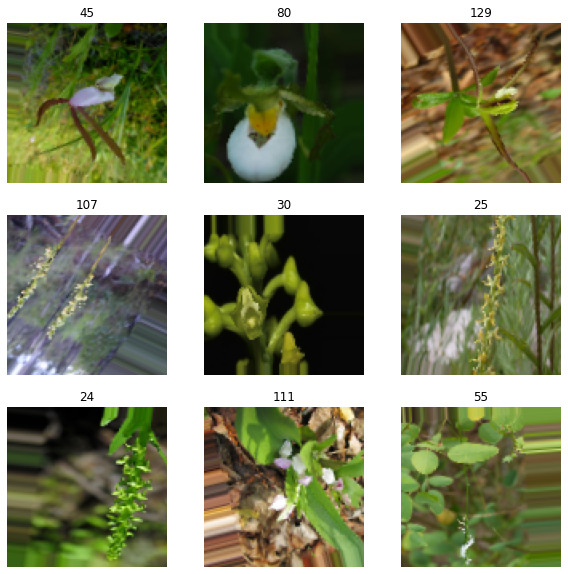

In [32]:
plt.figure(figsize=(10, 10))
labels = sample(range(0,batch),9)  # In our case the batch size is 128
pos = 1
for i in labels:
    ax = plt.subplot(3, 3, pos)
    plt.imshow(train_generator[0][0][i])  # generating from the 1st batch. First slicing is for batch, second for image or label and third for item in batch
    plt.title(int(train_generator[0][1][i]))   # generating from the 1st batch. First slicing is for batch, second for image or label and third for item in batch
    plt.axis("off")
    pos +=1

We can see the augmentation in work here.

#### Modeling

We will create our model and run it:

In [33]:
sinput = Input(shape=(image_size[0],image_size[1],3))

conv1 = Conv2D(32, (3, 3), padding='same' , activation = 'relu')(sinput)
conv2 = Conv2D(32, (3, 3) , activation = 'relu')(conv1)
maxp1 = MaxPooling2D(pool_size=(2, 2))(conv2)
dropout1 = Dropout(0.25)(maxp1)

conv3 = Conv2D(32, (3, 3), padding='same' , activation = 'relu')(dropout1)
conv4 = Conv2D(32, (3, 3) , activation = 'relu')(conv3)
maxp2 = MaxPooling2D(pool_size=(2, 2))(conv4)
dropout2 = Dropout(0.25)(maxp2)
                     
conv5 = Conv2D(32, (3, 3), padding='same' , activation = 'relu')(dropout2)
conv6 = Conv2D(32, (3, 3) , activation = 'relu')(conv5)
maxp3 = MaxPooling2D(pool_size=(2, 2))(conv6)
dropout3 = Dropout(0.25)(maxp3)

conv7 = Conv2D(32, (3, 3) , activation = 'relu')(dropout3)
flat1 = Flatten()(conv7)
dense1 = Dense(512 , activation = 'relu')(flat1)
dropout4 = Dropout(0.25)(dense1)

soutput = Dense(156, activation=tf.nn.softmax)(dropout4)

2022-09-06 16:40:52.138400: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-06 16:40:52.142318: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-06 16:40:52.142990: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-06 16:40:52.144070: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Keep it mind it was intentionally written this way (not the most elegant) for easier use in the features detection.

In [34]:
smodel = tf.keras.Model(inputs=sinput, outputs=soutput)

In [35]:
smodel.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 100, 100, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 98, 98, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 49, 49, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 47, 47, 32)        9248  

In [36]:
optimizer = keras.optimizers.RMSprop(learning_rate=0.0003)
smodel.compile(optimizer,loss="sparse_categorical_crossentropy",metrics=["accuracy"])

In [37]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

We will set an early monitor to prevent the model from overfitting. I chose relatively high patience for later explained reasons:

In [38]:
early_stopping_monitor = EarlyStopping( monitor="val_loss", min_delta=0, patience=8 , verbose=1, restore_best_weights=True)

Now we will run the model. Keep in mind this model is *very* slow and consuming so I highly recommend using GPU accelerator (Not the fastest with it either but improving):

In [39]:
history = smodel.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN, 
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=50,
                    verbose=1,
                    callbacks= early_stopping_monitor
)


2022-09-06 16:40:57.653731: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-09-06 16:41:00.657143: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


186/186 [==============================] - 193s 989ms/step - loss: 4.8466 - accuracy: 0.0219 - val_loss: 4.5687 - val_accuracy: 0.0305
Epoch 2/50
186/186 [==============================] - 160s 858ms/step - loss: 4.4273 - accuracy: 0.0574 - val_loss: 4.2505 - val_accuracy: 0.0511
Epoch 3/50
186/186 [==============================] - 159s 853ms/step - loss: 4.0818 - accuracy: 0.1008 - val_loss: 4.0871 - val_accuracy: 0.0575
Epoch 4/50
186/186 [==============================] - 157s 846ms/step - loss: 3.8356 - accuracy: 0.1388 - val_loss: 3.9500 - val_accuracy: 0.0845
Epoch 5/50
186/186 [==============================] - 158s 847ms/step - loss: 3.6534 - accuracy: 0.1724 - val_loss: 3.9013 - val_accuracy: 0.0795
Epoch 6/50
186/186 [==============================] - 159s 852ms/step - loss: 3.4846 - accuracy: 0.2024 - val_loss: 3.8616 - val_accuracy: 0.0966
Epoch 7/50
186/186 [==============================] - 158s 849ms/step - loss: 3.3322 - accuracy: 0.2292 - val_loss: 3.8550 - val_accura

#### Results

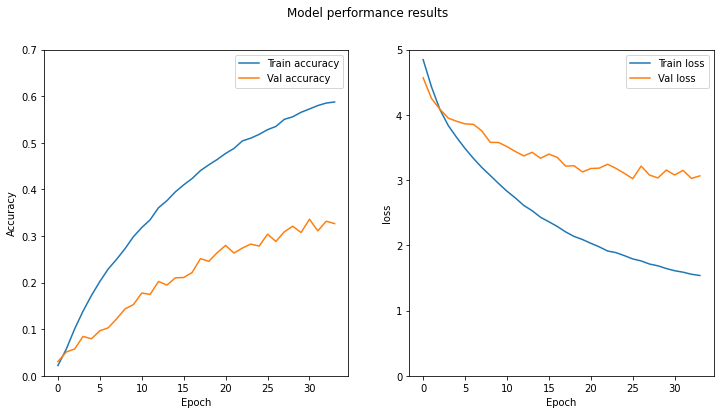

In [40]:
fig, (acc, loss) = plt.subplots(1 , 2)
fig.suptitle('Model performance results')


acc.plot(history.epoch, np.array(history.history['accuracy']), label='Train accuracy')
acc.plot(history.epoch, np.array(history.history['val_accuracy']), label = 'Val accuracy')
acc.set_xlabel('Epoch')
acc.set_ylabel('Accuracy')
acc.set_ylim([0, 0.7])
acc.legend(['Train accuracy','Val accuracy'])

loss.plot(history.epoch, np.array(history.history['loss']),label='Train loss')
loss.plot(history.epoch, np.array(history.history['val_loss']), label = 'Val loss')
loss.set_xlabel('Epoch')
loss.set_ylabel('loss')
loss.set_ylim([0, 5])
loss.legend(['Train loss','Val loss'])

fig.set_size_inches(12, 6)

In [41]:
results = np.argmax( smodel.predict(valid_generator) ,axis = 1)

In [42]:
 print(classification_report(valid_generator.classes, results , zero_division=0))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.00      0.00      0.00         2
           2       0.33      0.07      0.12        27
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         1
           5       0.25      0.33      0.29         6
           6       0.25      0.50      0.33         8
           7       0.09      0.33      0.14         3
           8       0.31      0.12      0.17        34
           9       0.00      0.00      0.00        15
          10       0.18      0.33      0.23         9
          11       0.12      0.33      0.18         3
          12       0.65      0.43      0.51        47
          13       0.75      0.29      0.42        31
          14       0.20      0.60      0.30         5
          15       0.08      0.33      0.13         3
          16       0.00      0.00      0.00         1
          17       0.10    

In [43]:
px.imshow(confusion_matrix(valid_generator.classes, results) , color_continuous_scale='RdBu_r' ,text_auto=True,  width=1400 , height=1400)

### ImageNet Pre-trained model

In [44]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(image_size[0],image_size[1],3),
                                               include_top=False,
                                               weights='imagenet')

9420800/9406464 [==============================] - 0s 0us/step


In [45]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 50, 50, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 50, 50, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 50, 50, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [46]:
base_model.trainable = False

In [47]:
ptinput = Input(shape=(image_size[0],image_size[1],3))
basemodel = base_model(ptinput, training=False)
max_pooling = GlobalAveragePooling2D()(basemodel)
dropout = Dropout(0.2)(max_pooling)
ptoutput = Dense(156, activation=tf.nn.softmax)(dropout)

In [48]:
ptmodel = tf.keras.Model(inputs=ptinput, outputs=ptoutput)

In [49]:
ptmodel.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 4, 4, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 156)               199836    
Total params: 2,457,820
Trainable params: 199,836
Non-trainable params: 2,257,984
_________________________________________________________________


In [50]:
ptmodel.compile(optimizer,loss="sparse_categorical_crossentropy",metrics=["accuracy"])

In [51]:
history = ptmodel.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN, 
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=50,
                    verbose=1,
                    callbacks= early_stopping_monitor
)


Epoch 1/50
186/186 [==============================] - 163s 864ms/step - loss: 4.4215 - accuracy: 0.1335 - val_loss: 3.9635 - val_accuracy: 0.1364
Epoch 2/50
186/186 [==============================] - 162s 868ms/step - loss: 3.1318 - accuracy: 0.3213 - val_loss: 3.4835 - val_accuracy: 0.2017
Epoch 3/50
186/186 [==============================] - 162s 867ms/step - loss: 2.6318 - accuracy: 0.4067 - val_loss: 3.2444 - val_accuracy: 0.2422
Epoch 4/50
186/186 [==============================] - 159s 852ms/step - loss: 2.3612 - accuracy: 0.4605 - val_loss: 3.1061 - val_accuracy: 0.2713
Epoch 5/50
186/186 [==============================] - 159s 853ms/step - loss: 2.1769 - accuracy: 0.4928 - val_loss: 3.0018 - val_accuracy: 0.2891
Epoch 6/50
186/186 [==============================] - 158s 850ms/step - loss: 2.0558 - accuracy: 0.5165 - val_loss: 2.9528 - val_accuracy: 0.3047
Epoch 7/50
186/186 [==============================] - 160s 859ms/step - loss: 1.9506 - accuracy: 0.5368 - val_loss: 2.9101 -

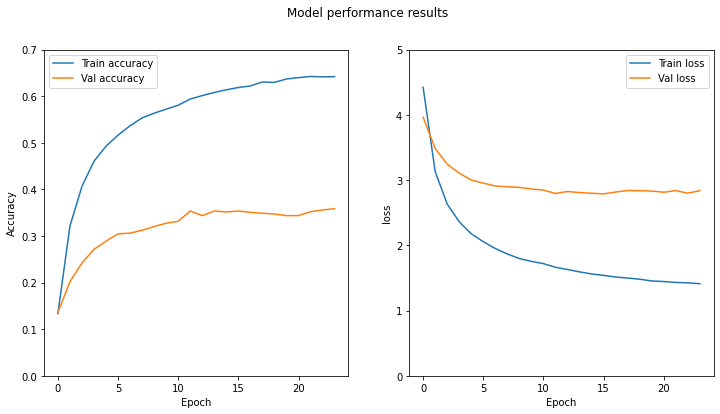

In [52]:
fig, (acc, loss) = plt.subplots(1 , 2)
fig.suptitle('Model performance results')


acc.plot(history.epoch, np.array(history.history['accuracy']), label='Train accuracy')
acc.plot(history.epoch, np.array(history.history['val_accuracy']), label = 'Val accuracy')
acc.set_xlabel('Epoch')
acc.set_ylabel('Accuracy')
acc.set_ylim([0, 0.7])
acc.legend(['Train accuracy','Val accuracy'])

loss.plot(history.epoch, np.array(history.history['loss']),label='Train loss')
loss.plot(history.epoch, np.array(history.history['val_loss']), label = 'Val loss')
loss.set_xlabel('Epoch')
loss.set_ylabel('loss')
loss.set_ylim([0, 5])
loss.legend(['Train loss','Val loss'])

fig.set_size_inches(12, 6)

In [53]:
results = np.argmax( ptmodel.predict(valid_generator) ,axis = 1)

In [54]:
print(classification_report(valid_generator.classes, results , zero_division=0))

              precision    recall  f1-score   support

           0       0.60      0.60      0.60         5
           1       0.04      0.50      0.08         2
           2       0.33      0.07      0.12        27
           3       0.17      0.50      0.25         2
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         6
           6       0.00      0.00      0.00         8
           7       0.20      0.33      0.25         3
           8       0.33      0.03      0.05        34
           9       0.00      0.00      0.00        15
          10       0.80      0.89      0.84         9
          11       0.17      0.67      0.27         3
          12       0.41      0.51      0.46        47
          13       0.38      0.26      0.31        31
          14       0.18      0.40      0.25         5
          15       0.00      0.00      0.00         3
          16       0.00      0.00      0.00         1
          17       0.00    

#### Discussion

As we can see, after ~25 epochs we reached an accuracy of ~35% and percision of ~44%. Though in abseloutle terms they are not relative good results, for our model they are great. Our data is extremely unbalanced. Many classes had approx. 3 items while others had 300+. This extreme bias in classes representation is very had to solve without adding more data to our model. By naive selecting model , we would have gotten a ~5% accuracy, so those results are an improve. The augmentation also played a necessary role in the model. Random oversampling basically duplicates minority classes, so augmentation was needed to insert some diffrenciation to our model rather than it memorizing the images from minority classes.

On the other hand, our model is very slow, even with the GPU acceleration. Unfortunately we had to sacrifice time over performance, as we already barely squeezed good performance of this model. There is the possibility of not oversampling our data which massively accelerates our model, but it causes 20-30% reduction in our accuracy and percision.

To improve the model, we suggest adding more data for minority classes. This is perhaps the most important issue to solve.

In [55]:
px.imshow(confusion_matrix(valid_generator.classes, results) , color_continuous_scale='RdBu_r' ,text_auto=True,  width=1400 , height=1400)

--------------------------------------

### Features

Now we would also like to predict the features of each orchid. One possibility is rebuilding a model, but it is completely unnecessary and wastful (We've already seen how long it takes to train a similar-sized model). Instead we will use the transfer learning approach. We have already built a model trained on the same orchid images so so we can just use change the output layer every time to suit the output classes of each feature (This is also why the model was written the way it was).

First, we will check the distribution of classes in each feature to look for unbalanceness if exists:

In [56]:
fig = make_subplots(rows=3, cols=2)
fig.add_trace( go.Histogram(x=total_df['Flowers Color'] , name='Flowers Color distribution'), row=1, col=1)
fig.add_trace( go.Histogram(x=total_df['Labell Color'] , name='Labellum Color distribution'), row=1, col=2)
fig.add_trace( go.Histogram(x=total_df['Inflorescence'] , name='Inflorescence distribution'), row=2, col=1)
fig.add_trace( go.Histogram(x=total_df['Labell Char'] , name='Labellum Characteristic distribution'), row=2, col=2)
fig.add_trace( go.Histogram(x=total_df['No Of Flowers'] , name='Number of Flowers distribution'), row=3, col=1)
fig.add_trace( go.Histogram(x=total_df['Texture'] , name='Texture distribution'), row=3, col=2)
fig.update_layout(title_text="Features count")
fig.show()


We can already see all of our features are also unbalanced. 

Now we will rebuild the process in the species section in functions, so we can call them for each feature instead of writing the same 6 times. Due to the length of the code is was hidden but you can reveal it to see how it was build:

In [57]:
def train_test_split(train_index,valid_index): # I intentioally did not shuffle the indexes for every feature to keep the performances comparable as much as possible
    train_df = total_df.iloc[train_index]
    valid_df = total_df.iloc[valid_index]
    return train_df ,valid_df


def train_test_balancer(train, test, feature):
    train_df = train
    valid_df = test

    unbalanced = [n for n in train_df[feature].unique() if n not in valid_df[feature].unique()]
    for item in unbalanced:
        unbalanced_df = train_df[train_df[feature] == item]
        items_to_move = floor(unbalanced_df.shape[0]*0.8)
        moving_indexes = sample(list(unbalanced_df.index), items_to_move)
        valid_df = valid_df.append(train_df.loc[moving_indexes])
        train_df.drop(axis=0 , index=moving_indexes , inplace=True)
        
    unbalanced = [n for n in valid_df[feature].unique() if n not in train_df[feature].unique()]
    for item in unbalanced:
        unbalanced_df = valid_df[valid_df[feature] == item]
        items_to_move = floor(unbalanced_df.shape[0]*0.8)
        moving_indexes = sample(list(unbalanced_df.index), items_to_move)
        train_df = train_df.append(valid_df.loc[moving_indexes])
        valid_df.drop(axis=0 , index=moving_indexes , inplace=True)
        
    f_train_df = mean_oversampler(train_df.reset_index() , 'Species' , 'Species')
    return f_train_df , valid_df


def train_test_generator(train , test , feature , batch , image_size ):
    train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=30, width_shift_range=0.2, height_shift_range=0.2, zoom_range=0.2, horizontal_flip=True, vertical_flip=True,)
    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_dataframe(
    dataframe= train,
    directory="../input/7156-orchid-pictures-156-species/Orchid Flowers Dataset-v1.1/Orchid_Images",
    x_col="Image_number",
    y_col=feature,
    validate_filenames=False,
    subset=None,
    batch_size=batch,
    seed=42,
    shuffle=True,
    class_mode="sparse",
    save_format="png",
    target_size=image_size)

    valid_generator = test_datagen.flow_from_dataframe(
    dataframe= test,
    directory="../input/7156-orchid-pictures-156-species/Orchid Flowers Dataset-v1.1/Orchid_Images",
    x_col="Image_number",
    y_col=feature,
    validate_filenames=False,
    subset=None,
    batch_size=batch,
    seed=42,
    shuffle=False,
    save_format="png",
    class_mode="sparse",
    target_size=image_size)
    return train_generator , valid_generator


#### Model & Results

Pay attention that we **did not** freeze the model and instead immediately fine tuned it to achieve better results. What we did do is to alter the learning rate to a lower rate as we only fine-tune the model to the new output layer.Also ,t o prevent the model from overfitting , we altered the early stopping monitor to be more strict so it will stop the model earlier once it detects overfitting:

In [58]:
for feature in features.keys():
    batch = 128
    image_size = (100,100)
    
    print(f'==================================================[{feature}]==================================================')
    f_train , f_valid = train_test_split(train_index,valid_index)
    f_train , f_valid = train_test_balancer(f_train , f_valid, feature)
    
    if len(train_df.rename(columns={'Labell Color' : 'Labell_Color'}).query("Labell_Color == ''"))!= 0:
        f_train.drop(axis=1 , index=1992 , inplace=True)
    elif len(valid_df.rename(columns={'Labell Color' : 'Labell_Color'}).query("Labell_Color == ''"))!= 0:
        f_valid.drop(axis=1 , index=1992 , inplace=True)

        
    f_train_generator , f_valid_generator = train_test_generator(f_train , f_valid , feature , batch , image_size)
    
    #Adding the new output layer suitable for each feature
    foutput = Dense(f_train[feature].nunique(), activation=tf.nn.softmax)(dropout4)
    
    
    #Model initiating
    fmodel = tf.keras.Model(inputs=sinput, outputs=foutput)
    fmodel.compile(optimizer,loss="sparse_categorical_crossentropy",metrics=["accuracy"])
    
    STEP_SIZE_TRAIN=f_train_generator.n//f_train_generator.batch_size
    STEP_SIZE_VALID=f_valid_generator.n//f_valid_generator.batch_size
    
    #fmodel.trainable = False
    
    #Optimizer
    optimizer = keras.optimizers.RMSprop(learning_rate=0.0001)
    fmodel.compile(optimizer,loss="sparse_categorical_crossentropy",metrics=["accuracy"])
    
    #Early stopping monitor
    early_stopping_monitor = EarlyStopping( monitor="val_loss", min_delta=0, patience=3 , verbose=1, restore_best_weights=True)
    
    #Output
    print('\n------------[Model]------------')
    history= fmodel.fit(f_train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=f_valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=20,  # We dont need to heavily train the model with many epochs rather we just fine tune it
                    verbose=1,
                    callbacks= early_stopping_monitor)
    
    print('\n------------[Results]------------')
    results = np.argmax( fmodel.predict(f_valid_generator) ,axis = 1)
    print(classification_report(f_valid_generator.classes, results))
    f_confusion_mat = px.imshow(confusion_matrix(f_valid_generator.classes, results) , color_continuous_scale='RdBu_r' ,text_auto=True, width=500 , height=500)
    f_confusion_mat.show()
    

==================================================[Flowers Color]==================================================
Found 23913 non-validated image filenames belonging to 15 classes.
Found 1432 non-validated image filenames belonging to 15 classes.

------------[Model]------------
Epoch 1/20
186/186 [==============================] - 161s 858ms/step - loss: 2.0641 - accuracy: 0.2993 - val_loss: 1.9136 - val_accuracy: 0.3516
Epoch 2/20
186/186 [==============================] - 159s 854ms/step - loss: 1.7928 - accuracy: 0.3770 - val_loss: 1.8567 - val_accuracy: 0.3643
Epoch 3/20
186/186 [==============================] - 159s 851ms/step - loss: 1.6782 - accuracy: 0.4159 - val_loss: 1.8338 - val_accuracy: 0.3729
Epoch 4/20
186/186 [==============================] - 160s 859ms/step - loss: 1.6047 - accuracy: 0.4461 - val_loss: 1.8026 - val_accuracy: 0.3970
Epoch 5/20
186/186 [==============================] - 159s 854ms/step - loss: 1.5513 - accuracy: 0.4655 - val_loss: 1.8039 - val_accur

==================================================[Labell Color]==================================================
Found 23913 non-validated image filenames belonging to 10 classes.
Found 1432 non-validated image filenames belonging to 11 classes.

------------[Model]------------
Epoch 1/20
186/186 [==============================] - 160s 856ms/step - loss: 1.5226 - accuracy: 0.4736 - val_loss: nan - val_accuracy: 0.0178
Epoch 2/20
186/186 [==============================] - 159s 856ms/step - loss: 1.3158 - accuracy: 0.5403 - val_loss: nan - val_accuracy: 0.0163
Epoch 3/20
186/186 [==============================] - 161s 862ms/step - loss: 1.2468 - accuracy: 0.5662 - val_loss: nan - val_accuracy: 0.0185
Restoring model weights from the end of the best epoch.
Epoch 00003: early stopping

------------[Results]------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00       139
        

==================================================[Inflorescence]==================================================
Found 23913 non-validated image filenames belonging to 4 classes.
Found 1432 non-validated image filenames belonging to 4 classes.

------------[Model]------------
Epoch 1/20
186/186 [==============================] - 162s 864ms/step - loss: 1.0280 - accuracy: 0.5520 - val_loss: 0.9355 - val_accuracy: 0.6165
Epoch 2/20
186/186 [==============================] - 162s 868ms/step - loss: 0.9238 - accuracy: 0.6067 - val_loss: 0.9180 - val_accuracy: 0.6335
Epoch 3/20
186/186 [==============================] - 161s 864ms/step - loss: 0.8809 - accuracy: 0.6264 - val_loss: 0.9118 - val_accuracy: 0.6378
Epoch 4/20
186/186 [==============================] - 161s 864ms/step - loss: 0.8415 - accuracy: 0.6509 - val_loss: 0.9020 - val_accuracy: 0.6420
Epoch 5/20
186/186 [==============================] - 161s 862ms/step - loss: 0.8186 - accuracy: 0.6578 - val_loss: 0.9052 - val_accurac

==================================================[Labell Char]==================================================
Found 23913 non-validated image filenames belonging to 4 classes.
Found 1432 non-validated image filenames belonging to 4 classes.

------------[Model]------------
Epoch 1/20
186/186 [==============================] - 162s 865ms/step - loss: 1.0800 - accuracy: 0.5110 - val_loss: 1.0348 - val_accuracy: 0.5362
Epoch 2/20
186/186 [==============================] - 158s 850ms/step - loss: 0.9489 - accuracy: 0.5908 - val_loss: 1.0220 - val_accuracy: 0.5547
Epoch 3/20
186/186 [==============================] - 159s 854ms/step - loss: 0.9016 - accuracy: 0.6166 - val_loss: 1.1062 - val_accuracy: 0.5092
Epoch 4/20
186/186 [==============================] - 159s 853ms/step - loss: 0.8785 - accuracy: 0.6300 - val_loss: 1.0452 - val_accuracy: 0.5483
Epoch 5/20
186/186 [==============================] - 160s 857ms/step - loss: 0.8514 - accuracy: 0.6479 - val_loss: 1.0294 - val_accuracy:

==================================================[No Of Flowers]==================================================
Found 23913 non-validated image filenames belonging to 3 classes.
Found 1432 non-validated image filenames belonging to 3 classes.

------------[Model]------------
Epoch 1/20
186/186 [==============================] - 159s 851ms/step - loss: 0.8814 - accuracy: 0.5864 - val_loss: 0.9382 - val_accuracy: 0.5597
Epoch 2/20
186/186 [==============================] - 159s 853ms/step - loss: 0.8105 - accuracy: 0.6324 - val_loss: 0.9527 - val_accuracy: 0.5533
Epoch 3/20
186/186 [==============================] - 159s 857ms/step - loss: 0.7794 - accuracy: 0.6517 - val_loss: 0.9309 - val_accuracy: 0.5668
Epoch 4/20
186/186 [==============================] - 159s 854ms/step - loss: 0.7611 - accuracy: 0.6632 - val_loss: 0.9261 - val_accuracy: 0.5838
Epoch 5/20
186/186 [==============================] - 158s 853ms/step - loss: 0.7414 - accuracy: 0.6769 - val_loss: 0.9155 - val_accurac

==================================================[Texture]==================================================
Found 23913 non-validated image filenames belonging to 2 classes.
Found 1432 non-validated image filenames belonging to 2 classes.

------------[Model]------------
Epoch 1/20
186/186 [==============================] - 162s 866ms/step - loss: 0.4492 - accuracy: 0.7952 - val_loss: 0.4364 - val_accuracy: 0.8210
Epoch 2/20
186/186 [==============================] - 160s 862ms/step - loss: 0.4081 - accuracy: 0.8212 - val_loss: 0.4420 - val_accuracy: 0.8139
Epoch 3/20
186/186 [==============================] - 158s 849ms/step - loss: 0.3955 - accuracy: 0.8294 - val_loss: 0.4678 - val_accuracy: 0.7947
Epoch 4/20
186/186 [==============================] - 159s 855ms/step - loss: 0.3892 - accuracy: 0.8325 - val_loss: 0.4275 - val_accuracy: 0.8281
Epoch 5/20
186/186 [==============================] - 159s 852ms/step - loss: 0.3823 - accuracy: 0.8361 - val_loss: 0.4380 - val_accuracy: 0.8

--------------------------------------

### Summary

To summarize , we have built a model to detect orchid species & features. The biggest problem of the data was its unbalancedness. It was a major flaw as oversampling and data augmentation did improve our model performance by a bit, but on expence of slowing it down. Overall the ~45% percision is not bad for this type of troubled data, however the only way to improve its performance would be just collecting more data of underrepresented classes.

The transfer learning method was an excellent method to use the model to detect also the other features of the orchids. The percision of detection was better than naive model but mediocre for a CNN model. I believe the issue also lies of the unbalancedness of the data. Almost all features are also heavily unbalanced and the model was trained on the training data **balanced by species and not the features**. This limited the effectiveness of detecting features however was the last resort as balancing the model by every feature would create an even larger training dataset massively slowing down the model. The current choice was the best of time-accuracy-computational power tradeoff. Once again the most important improvement suggestion is to collect more data from the underrepresented different features classes.